In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from anndata import AnnData
from scipy.io import mmread
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb

In [6]:
#data_loc="I:\\mutiomics\\ICC\\BMK240704-CD182-ZX01-0101\\BMK_DATA_20240828172206_1\\Matrix\\backup\\Unknown_CD182-0050001_BSTViewer_project\\level_matrix\\level_6\\"
data_loc="I:\\mutiomics\\ICC\\BMK240704-CD182-ZX01-0102\\BMK_DATA_20241128174824_1\\backup\\Unknown_CD182-0060001_BSTViewer_project\\subdata\\L6_heAuto\\"
expression_matrix = mmread(f"{data_loc}matrix.mtx.gz").tocsc()
spatial_coords = pd.read_csv(f"{data_loc}barcodes_pos.tsv.gz", sep='\t', header=None)

In [7]:
spatial_coords=spatial_coords.iloc[:,[1,2]]

In [8]:
min_values = np.min(spatial_coords, axis=0)
max_values = np.max(spatial_coords, axis=0)

# 执行 Min-Max Scaling 到 [0, 1000] 范围
scaled_spatial_coords = 1000 * (spatial_coords - min_values) / (max_values - min_values)

In [9]:
spatial_coords

,1,2
0,212.991718,110.270315
1,217.132505,107.580796
2,217.391304,112.511582
3,213.250518,115.201102
4,209.109731,117.890622
...,...,...
11741,884.057971,903.230429
11742,879.917184,905.919949
11743,875.776398,908.609469
11744,884.316770,908.161215


In [10]:
adata = AnnData(X=expression_matrix.T, obsm={'spatial': spatial_coords.values})

In [12]:
#print(expression_matrix.shape,spatial_coords.shape,cell_metadata.shape)
gene_metadata = pd.read_csv(f"{data_loc}features.tsv.gz", sep='\t', header=None)
adata.var_names = gene_metadata[1].values

In [14]:
image = Image.open(f"{data_loc}he_roi_small.png")
#image=image.resize((1024, 1024))
image_array = np.array(image)
library_id =  'sample_1'

# 将图像和相关信息添加到 AnnData 对象的 uns 中
adata.uns['spatial'] = {
    'sample_1': {  # 替换为实际 library_id
        'images': {
            'hires': image_array,  # 正确设置的图像数据
        },
        'scalefactors': {
            'tissue_hires_scalef': 1.02,
        }
    }
}
adata.uns['spatial'][library_id]['scalefactors']['spot_diameter_fullres'] = 5

In [15]:
image_array.shape

(1026, 1024, 3)

In [16]:
adata.obsm['spatial']

array([[212.99171843, 110.27031539],
       [217.13250518, 107.5807955 ],
       [217.39130435, 112.51158196],
       ...,
       [875.77639752, 908.60946867],
       [884.31677019, 908.16121536],
       [880.17598344, 910.85073524]])

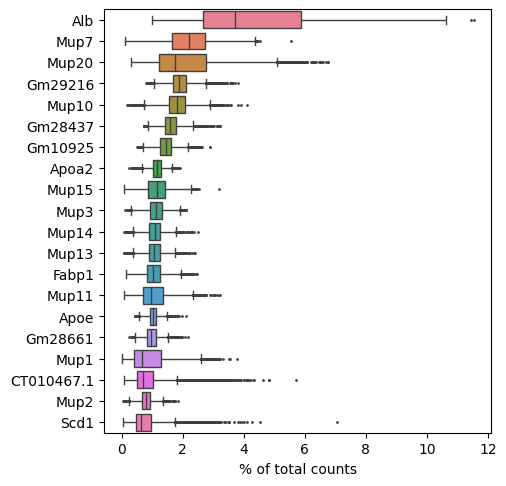

Number of cells after min count filter: 11741
Number of cells after max count filter: 11741
Number of cells after MT filter: 11741


I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\preprocessing\_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Number of cells after gene filter: 11741
Number of genes after cell filter: 19286


In [17]:
adata.var_names_make_unique()
adata
sc.pl.highest_expr_genes(adata, n_top=20)
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['total_counts'] = adata.X.sum(axis=1).A1
sc.pp.filter_cells(adata, min_counts =1500)
print(f'Number of cells after min count filter: {adata.n_obs}')
sc.pp.filter_cells(adata, max_counts = 200000)
print(f'Number of cells after max count filter: {adata.n_obs}')
adata = adata[adata.obs['mt_frac'] < 1]
print(f'Number of cells after MT filter: {adata.n_obs}')
sc.pp.filter_cells(adata, min_genes = 0)
print(f'Number of cells after gene filter: {adata.n_obs}')
sc.pp.filter_genes(adata, min_cells=10)
print(f'Number of genes after cell filter: {adata.n_vars}')

In [18]:
sc.pp.normalize_total(adata, inplace = True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, inplace=True)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata,n_neighbors=10)

sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='clusters')

I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\preprocessing\_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
C:\Users\28123\AppData\Local\Temp\ipykernel_5080\3490106758.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added='clusters')


-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.3.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.1
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.1
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
h5py                        3.11.0
idna                        3.7
igraph                      0.11.4
ipykernel                   6.29.4
ipywidgets                  8.1.2
isoduration                 N

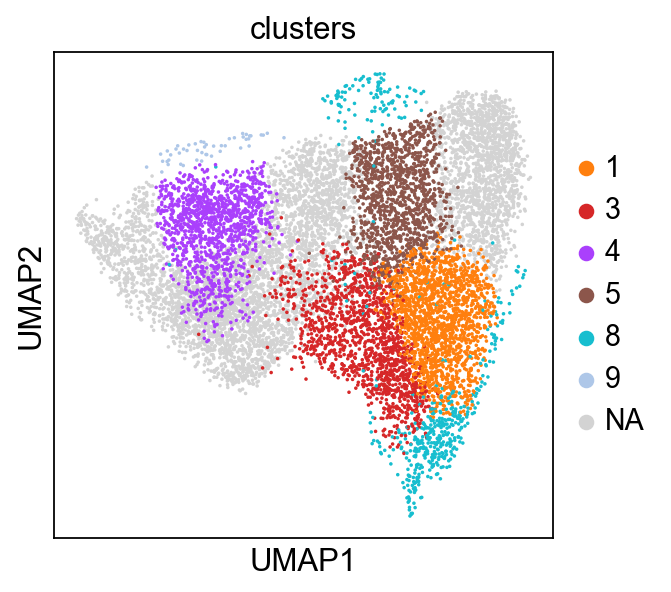

In [19]:
plt.rcParams['figure.figsize']=(8,8)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
sc.pl.umap(adata, color='clusters', palette=sc.pl.palettes.default_20,groups=["1","3","4","5","8","9","10"])

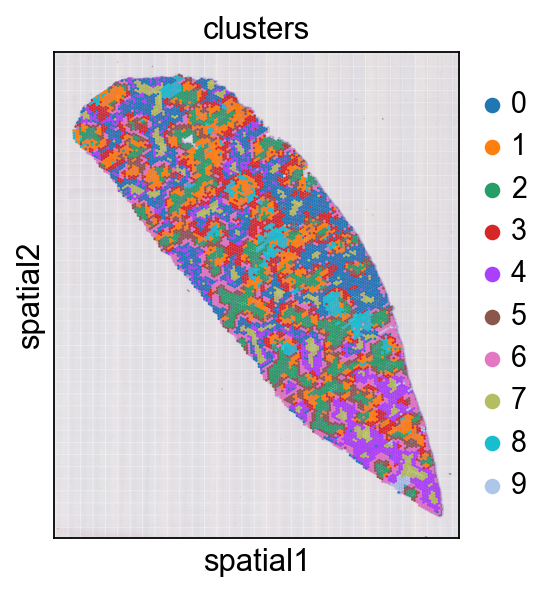

In [20]:
sc.pl.spatial(adata, img_key = "hires", color="clusters",size=1)

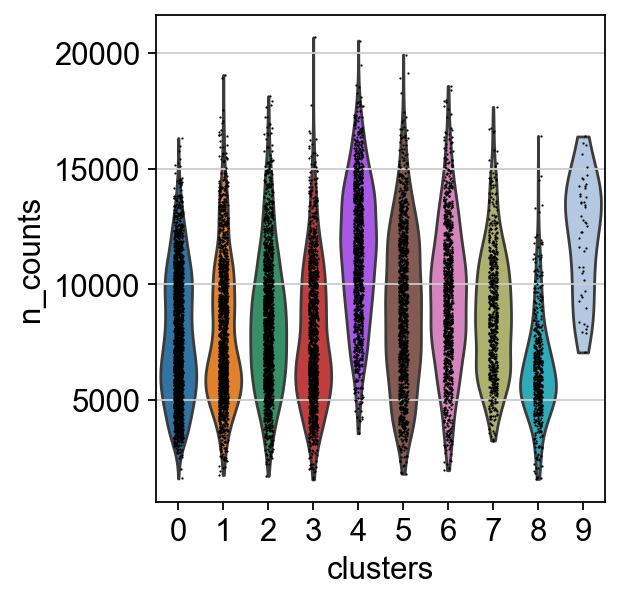

In [21]:
sc.pl.violin(adata, keys='n_counts', groupby='clusters')

In [22]:
adata.write(f"{data_loc}anndata.h5ad")